<a href="https://colab.research.google.com/github/Rogerio-mack/Temporal/blob/main/Copy_of_MLSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [248]:
df = pd.read_csv('https://github.com/Rogerio-mack/Temporal/raw/main/Data/london_merged.csv')
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [249]:
from datetime import datetime

df.timestamp = pd.to_datetime(df.timestamp)
df['year'] = df.timestamp.dt.year
df = df[df.year == 2015]
df = df.set_index('timestamp')

In [250]:
df_resample = df.copy()
# df_resample = df_resample.set_index('timestamp')
df_resample = df_resample.resample('D').max()

In [251]:
df_resample.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year
count,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.0
mean,3453.837017,15.682320,15.216851,86.544199,24.983886,6.348066,0.019337,0.284530,1.477901,2015.0
std,1102.062251,5.343198,5.986070,6.833556,8.147945,4.809427,0.137897,0.451815,1.114402,0.0
min,660.000000,3.000000,-0.500000,65.500000,8.000000,1.000000,0.000000,0.000000,0.000000,2015.0
25%,2834.250000,12.000000,12.000000,82.000000,19.000000,4.000000,0.000000,0.000000,0.000000,2015.0
50%,3721.000000,16.000000,16.000000,88.000000,24.000000,7.000000,0.000000,0.000000,1.000000,2015.0
75%,4268.750000,19.375000,19.375000,93.000000,30.000000,7.000000,0.000000,1.000000,2.000000,2015.0
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000,2015.0


In [252]:
df_resample.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year
timestamp,,,,,,,,,,
2015-01-04,1039,4.0,3.5,100.0,15.0,4.0,0.0,1.0,3.0,2015
2015-01-05,3161,10.0,9.0,93.0,14.0,4.0,0.0,0.0,3.0,2015
2015-01-06,3534,11.0,11.0,88.0,27.5,7.0,0.0,0.0,3.0,2015
2015-01-07,3618,10.0,7.0,87.0,30.5,7.0,0.0,0.0,3.0,2015
2015-01-08,2351,12.0,12.0,88.0,27.0,7.0,0.0,0.0,3.0,2015


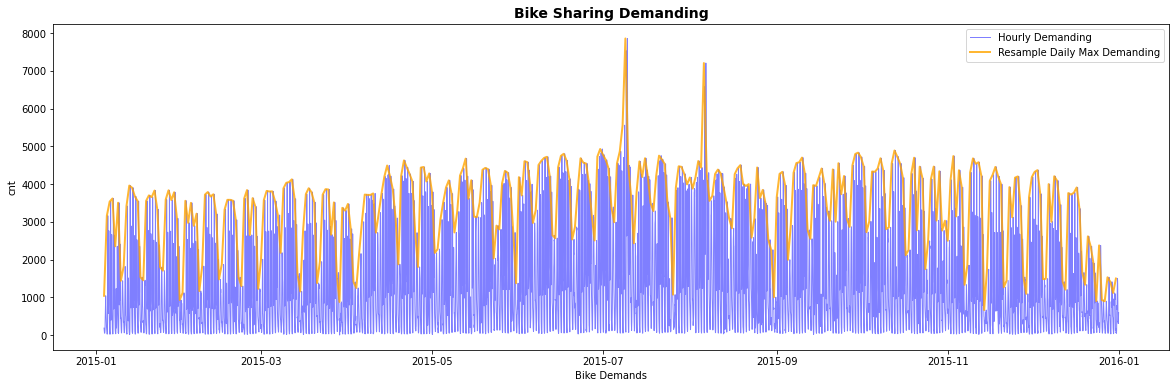

In [253]:
plt.figure(figsize=(20,6))

sns.lineplot(x = df.cnt.index, y = df.cnt, color='blue', alpha=0.5, label='Hourly Demanding',lw=1)
sns.lineplot(x = df_resample.cnt.index, y = df_resample.cnt, color='orange', alpha=0.8, label='Resample Daily Max Demanding',lw=2)

plt.title('Bike Sharing Demanding', fontsize=14, weight='bold')
plt.xlabel('Days Hours')
plt.xlabel('Bike Demands')
plt.show()

In [254]:
def ml_timeseries_df(df, n_lags, prefix=''):

	df_ml = pd.DataFrame()

	for i in range(n_lags,0,-1):
		df_ml[prefix + 't-' + str(i)] = df.shift(i).values[:,0]
	df_ml['t'] = df.values[:,0]
	df_ml = df_ml[n_lags:]
	df_ml = df_ml.reset_index(drop=True)

	return df_ml 

df = ml_timeseries_df(df_resample[['cnt']], n_lags=7)
df.head()

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,1039.0,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813
1,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418
2,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960
3,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904
4,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904.0,3673


In [255]:
def split_train_test(X, y, test_perc=0.2):
  
  test_size = int(len(df) * test_perc)
  train_size = len(df) - test_size

  X_train, y_train  = X[:train_size], y[:train_size]
  X_test, y_test = X[train_size:], y[train_size:]

  return X_train, y_train, X_test, y_test

X = df.drop(columns='t')
y = df[['t']] 

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

In [256]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X)

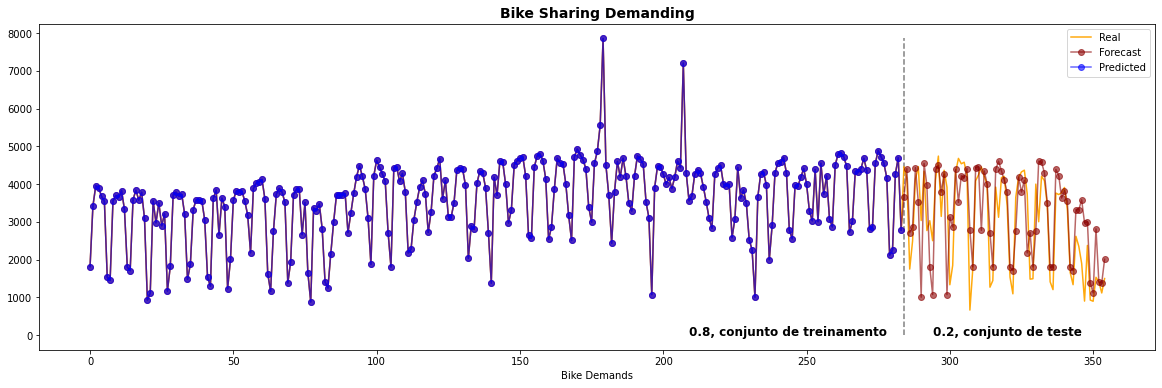

In [257]:
def plot_forecast(y, y_pred, X_train):

  plt.figure(figsize=(20,6))
  plt.plot(y, color='orange', alpha=0.95, label='Real')
  plt.plot(y_pred, color='darkred', alpha=0.6, label='Forecast', marker='o')
  plt.plot(y_pred[0:X_train.shape[0]], color='blue', alpha=0.6, label='Predicted', marker='o')

  plt.vlines(x=y.index[X_train.shape[0]] , ymin=0, ymax=y.max(), color='gray', linestyle='--')

  plt.title('Bike Sharing Demanding', fontsize=14, weight='bold')
  plt.xlabel('Days Hours')
  plt.xlabel('Bike Demands')

  plt.text(y.index[X_train.shape[0] - 75] , 0 , '0.8, conjunto de treinamento', fontsize=12, weight='bold')
  plt.text(y.index[X_train.shape[0] + 10] , 0 , '0.2, conjunto de teste', fontsize=12, weight='bold')
  plt.legend()
  plt.show()

  return

plot_forecast(y, y_pred, X_train) 



In [258]:
# Accuracy metrics
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual, print_flag=True):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)                           # ME
    mae = np.mean(np.abs(forecast - actual))                  # MAE
    mpe = np.mean((forecast - actual)/actual)                 # MPE
    mse = np.mean((forecast - actual)**2)                     # MSE
    rmse = np.mean((forecast - actual)**2)**.5                # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]                 # CORR
    acf1 = acf(forecast - actual)[1]                          # ACF1

    metrics = {'MSE':mse, 'MAPE':mape, 'ME':me, 'MAE': mae, 'MPE': mpe, 'RMSE':rmse, 'ACF1':acf1, 'CORR':corr}

    if print_flag:
      for key, value in metrics.items():
        print(f'{key}: \t {value:.2f}')
    
    return metrics

dict_metrics = {}

cur_metrics = forecast_accuracy(y_pred[len(y_train):], y[len(y_train):].values.reshape(-1))
dict_metrics['DecisionTreeRegressor'] = cur_metrics

MSE: 	 865131.56
MAPE: 	 0.34
ME: 	 180.15
MAE: 	 687.96
MPE: 	 0.20
RMSE: 	 930.12
ACF1: 	 0.07
CORR: 	 0.72


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [259]:
from sklearn.ensemble import GradientBoostingRegressor

regressor =  GradientBoostingRegressor(random_state=0)

regressor.fit(X_train,y_train.values.reshape(-1))

y_pred = regressor.predict(X)

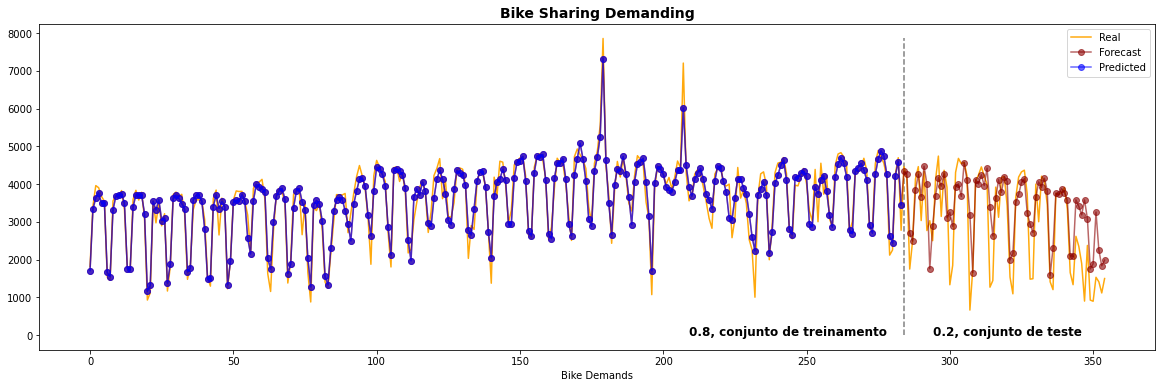

MSE: 	 755297.04
MAPE: 	 0.40
ME: 	 369.84
MAE: 	 643.09
MPE: 	 0.33
RMSE: 	 869.08
ACF1: 	 0.15
CORR: 	 0.80


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [260]:
plot_forecast(y, y_pred, X_train) 

cur_metrics = forecast_accuracy(y_pred[len(y_train):], y[len(y_train):].values.reshape(-1))
dict_metrics['GradientBoostingRegressor'] = cur_metrics

In [261]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(hidden_layer_sizes=(8), random_state=1, max_iter=2000)

regr.fit(X_train,y_train.values.reshape(-1))

y_pred = regr.predict(X)



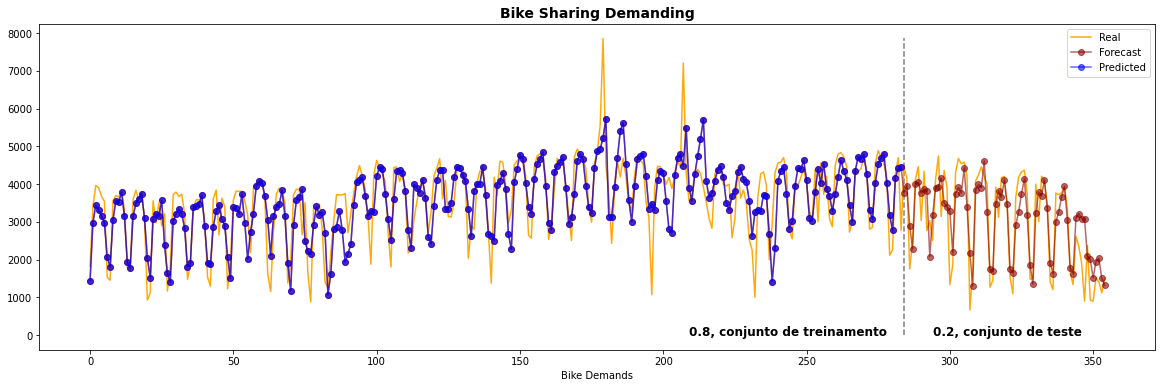

MSE: 	 479910.77
MAPE: 	 0.29
ME: 	 41.79
MAE: 	 563.62
MPE: 	 0.15
RMSE: 	 692.76
ACF1: 	 -0.06
CORR: 	 0.85


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [262]:
plot_forecast(y, y_pred, X_train) 

cur_metrics = forecast_accuracy(y_pred[len(y_train):], y[len(y_train):].values.reshape(-1))
dict_metrics['MLPRegressor'] = cur_metrics

In [263]:
print('Mean Absolute Error')
print()
 
for key, item in dict_metrics.items():
  print(f"{key} MAE: {item['MAE']:.2f}")

Mean Absolute Error

DecisionTreeRegressor MAE: 687.96
GradientBoostingRegressor MAE: 643.09
MLPRegressor MAE: 563.62


In [264]:
df_wind = ml_timeseries_df(df_resample[['wind_speed']], n_lags=7, prefix='wind_')
df_wind.head()

,wind_t-7,wind_t-6,wind_t-5,wind_t-4,wind_t-3,wind_t-2,wind_t-1,t
0,15.0,14.0,27.5,30.5,27.0,44.0,48.0,37.0
1,14.0,27.5,30.5,27.0,44.0,48.0,37.0,39.0
2,27.5,30.5,27.0,44.0,48.0,37.0,39.0,30.0
3,30.5,27.0,44.0,48.0,37.0,39.0,30.0,40.0
4,27.0,44.0,48.0,37.0,39.0,30.0,40.0,45.0


In [265]:
df = pd.concat([df_wind.drop(columns='t'), df],axis=1)
df.head()


,wind_t-7,wind_t-6,wind_t-5,wind_t-4,wind_t-3,wind_t-2,wind_t-1,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,15.0,14.0,27.5,30.5,27.0,44.0,48.0,1039.0,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813
1,14.0,27.5,30.5,27.0,44.0,48.0,37.0,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418
2,27.5,30.5,27.0,44.0,48.0,37.0,39.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960
3,30.5,27.0,44.0,48.0,37.0,39.0,30.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904
4,27.0,44.0,48.0,37.0,39.0,30.0,40.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904.0,3673


In [266]:
X = df.drop(columns='t')
y = df[['t']] 

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

In [267]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(hidden_layer_sizes=(8,16,8), random_state=1, max_iter=2000)

regr.fit(X_train,y_train.values.reshape(-1))

y_pred = regr.predict(X)



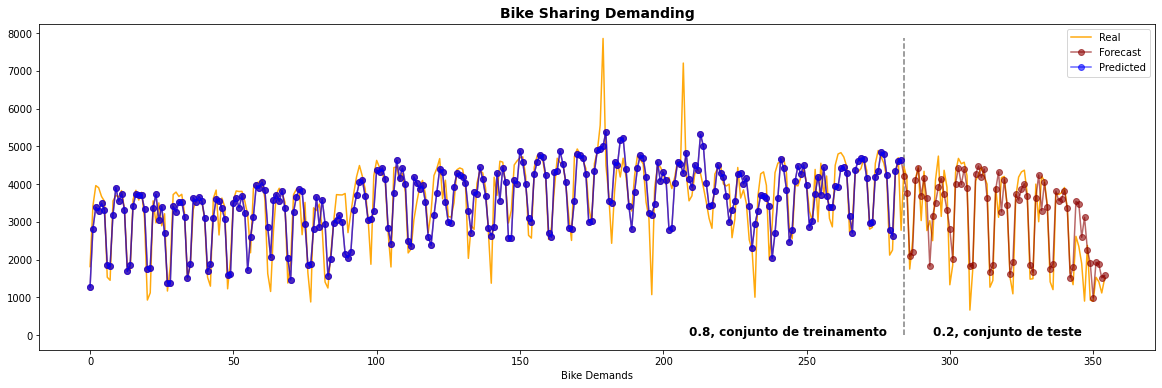

MSE: 	 386396.82
MAPE: 	 0.24
ME: 	 126.38
MAE: 	 459.65
MPE: 	 0.16
RMSE: 	 621.61
ACF1: 	 -0.11
CORR: 	 0.88


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [268]:
plot_forecast(y, y_pred, X_train) 

cur_metrics = forecast_accuracy(y_pred[len(y_train):], y[len(y_train):].values.reshape(-1))
dict_metrics['MLPRegressor with 2 input series'] = cur_metrics

In [269]:
print('Mean Absolute Error')
print()
 
for key, item in dict_metrics.items():
  print(f"{key} MAE: {item['MAE']:.2f}")

Mean Absolute Error

DecisionTreeRegressor MAE: 687.96
GradientBoostingRegressor MAE: 643.09
MLPRegressor MAE: 563.62
MLPRegressor with 2 input series MAE: 459.65


# Arima

In [270]:
from statsmodels.tsa.arima_model import ARIMA

In [271]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf

In [272]:
df = df_resample[['cnt']]
df.columns = ['value']
df = df.reset_index(drop=True)
df.head()

,value
0,1039
1,3161
2,3534
3,3618
4,2351


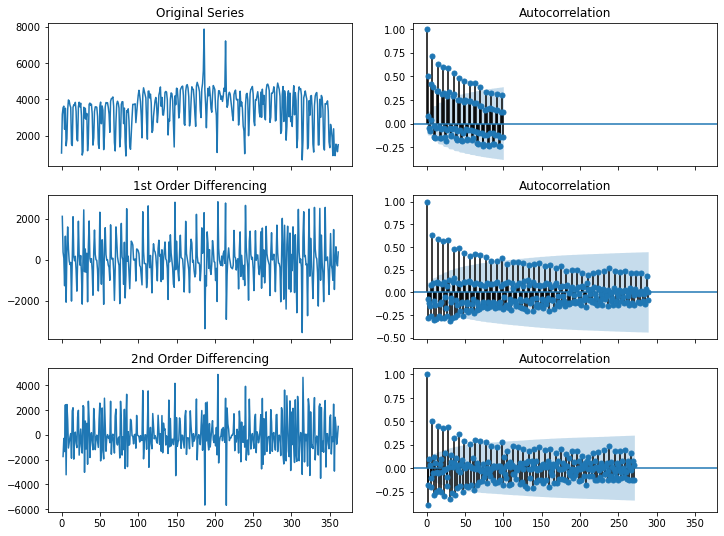

In [273]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(12,9)) 

axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1], lags=100) 

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1], lags=int(0.80 * len(df)))

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1], lags=int(0.75 * len(df))) 

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


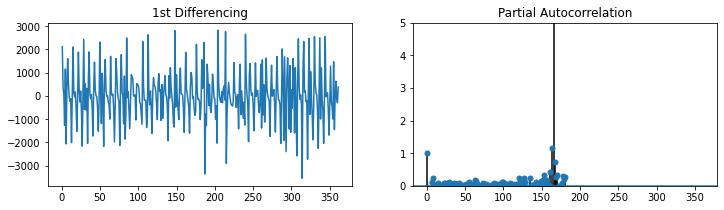

In [274]:
# PACF plot of 1st differenced series

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,3)) 
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1],lags=int(0.5 * len(df) - 1))

plt.show()

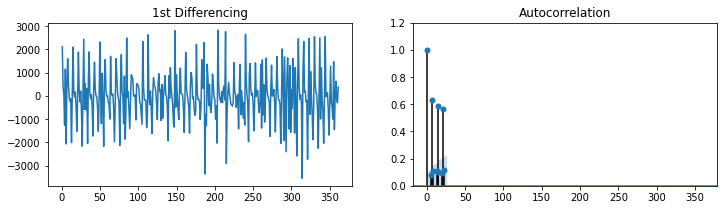

In [275]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,3)) 
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

In [276]:
test_size = int(0.2*len(df))
train_size = len(df) - test_size
# Create Training and Test
train = df.value[:train_size]
test = df.value[train_size:]

In [277]:
p = 7
d = 2
q = 1

model = ARIMA(train, order=(p,d,q))
model_fit = model.fit()


In [278]:
yhat = model_fit.predict(p+1,len(df),dynamic=False)

# yhat2, se, conf = model_fit.forecast(len(df)-p, alpha=0.05)  # 95% conf

# yhat = yhat + yhat2

In [279]:
model_fit.fittedvalues

2        -0.053076
3       705.698168
4       774.518661
5      1373.568612
6      -422.823467
          ...     
285    -266.625658
286    -667.662249
287    2742.788291
288    1593.522377
289   -1600.800589
Length: 288, dtype: float64

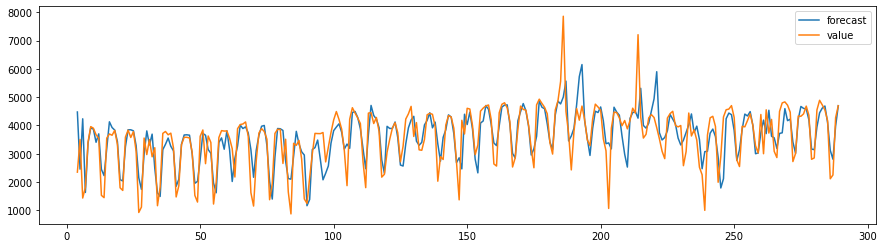

In [280]:
fig, ax = plt.subplots(figsize=(15, 4))

model_fit.plot_predict(dynamic=False, ax=ax)
plt.show()

In [281]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  288
Model:                 ARIMA(7, 2, 1)   Log Likelihood               -2284.963
Method:                       css-mle   S.D. of innovations            660.127
Date:                Tue, 01 Mar 2022   AIC                           4589.925
Time:                        22:34:44   BIC                           4626.555
Sample:                             2   HQIC                          4604.604
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0531      0.105     -0.503      0.615      -0.260       0.154
ar.L1.D2.value    -0.5977      0.059    -10.116      0.000      -0.714      -0.482
ar.L2.D2.value    -0.6655      0.064

In [282]:
                        
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in test.index:
	# print(t)
	model = ARIMA(history, order=(7,2,1))
	model_fit = model.fit( )
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

    


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarni

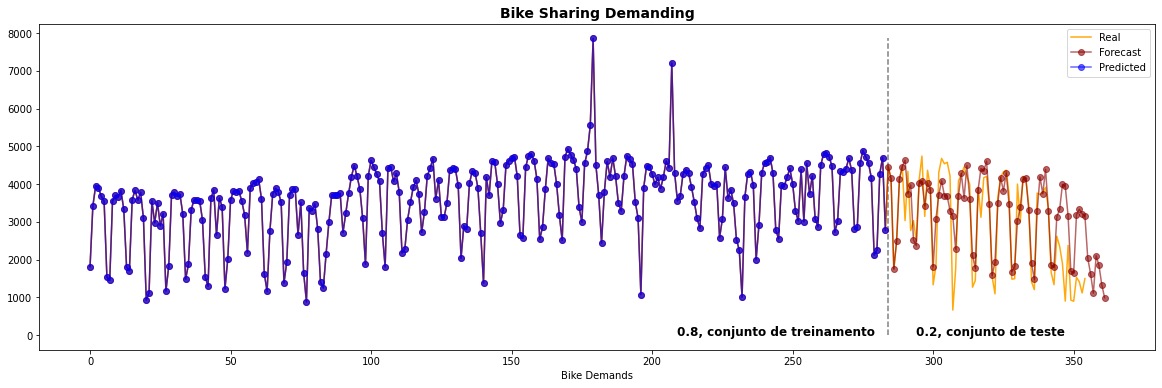

MSE: 	 479701.79
MAPE: 	 0.27
ME: 	 109.29
MAE: 	 535.00
MPE: 	 0.16
RMSE: 	 692.61
ACF1: 	 -0.12
CORR: 	 0.84


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [283]:
y_pred = np.concatenate( (np.array( y[0:train_size] ).reshape(-1), np.array(predictions).reshape(-1)) )

plot_forecast(y, y_pred, X_train) 
cur_metrics = forecast_accuracy(y_pred[train_size::], df[train_size::].values.reshape(-1))

dict_metrics['ARIMA Model'] = cur_metrics

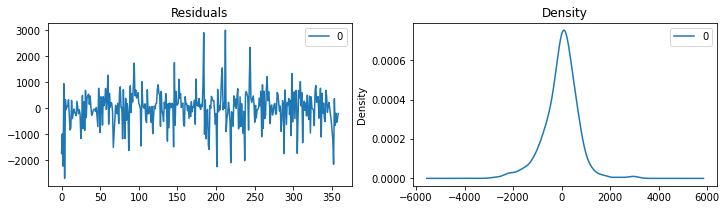

In [284]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2,figsize=(12,3)) 
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Deep Learning

In [285]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [286]:
df = ml_timeseries_df(df_resample[['cnt']], n_lags=7)
df.head(7)

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,1039.0,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813
1,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418
2,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960
3,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904
4,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904.0,3673
5,3505.0,1436.0,1813.0,3418.0,3960.0,3904.0,3673.0,3546
6,1436.0,1813.0,3418.0,3960.0,3904.0,3673.0,3546.0,1531


In [287]:
min = df.min().min()
max = df.max().max()

In [288]:
max

7860.0

In [289]:
for c in df:
  df[c] = ( df[c] - min ) / ( max - min )

In [290]:
df.head(7)

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,0.052639,0.347361,0.399167,0.410833,0.234861,0.395139,0.107778,0.160139
1,0.347361,0.399167,0.410833,0.234861,0.395139,0.107778,0.160139,0.383056
2,0.399167,0.410833,0.234861,0.395139,0.107778,0.160139,0.383056,0.458333
3,0.410833,0.234861,0.395139,0.107778,0.160139,0.383056,0.458333,0.450556
4,0.234861,0.395139,0.107778,0.160139,0.383056,0.458333,0.450556,0.418472
5,0.395139,0.107778,0.160139,0.383056,0.458333,0.450556,0.418472,0.400833
6,0.107778,0.160139,0.383056,0.458333,0.450556,0.418472,0.400833,0.120972


In [291]:
X = df.drop(columns='t')
y = df[['t']] 

X = torch.tensor(np.array(X)).unsqueeze(-1) 
y = torch.tensor(np.array(y))

X = X.type(torch.float)
y = y.type(torch.float)

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

In [292]:
X.shape

torch.Size([355, 7, 1])

In [293]:
y.shape

torch.Size([355, 1])

In [294]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (h_out, cn) = self.lstm(x)
     
        h_out = h_out[-1]                         # saída da última camada para a camada fc
        h_out = h_out.view(-1,self.hidden_size)  
        out_final = self.fc(h_out)

        return out_final

In [295]:
def train(model, optmizer, loss_f, num_epochs, data_train_x, data_train_y):

  for epoch in range(num_epochs):
    
    outputs = model(data_train_x)
    loss = loss_f(outputs, data_train_y)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    if epoch % 500 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [296]:
device = 'cpu' 
num_epochs = 2000
learning_rate = 0.01

input_size = 1 # input size!!! uma única série de dados
hidden_size = 8

for num_layers in range(2,3):

  # num_layers = 1, 2, 3, 4

  model = LSTM(input_size, hidden_size, num_layers)
  model = model.to(device)

  loss_function = torch.nn.MSELoss()    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train(model, optimizer, loss_function, num_epochs, X_train, y_train)

  model.eval()


Epoch: 0, loss: 0.66171
Epoch: 500, loss: 0.00871
Epoch: 1000, loss: 0.00587
Epoch: 1500, loss: 0.00387


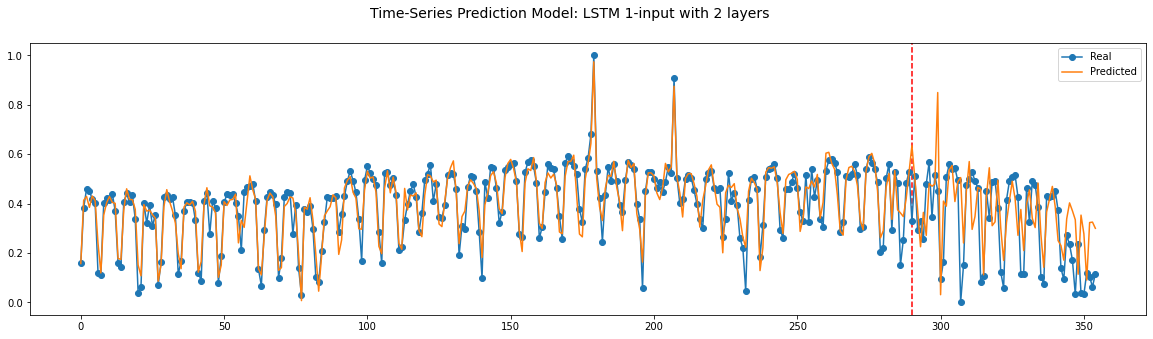

In [297]:
  prediction = model(X.to(device))
  data_predict = prediction.to('cpu').data.numpy()
  dataY_plot = y.to('cpu').data.numpy()

  plt.figure(figsize=(20,5))
  plt.axvline(x=train_size, c='r', linestyle='--')
  plt.plot(dataY_plot, marker='o', label='Real')
  plt.plot(data_predict, Label='Predicted')
  plt.legend()
  plt.suptitle(f'Time-Series Prediction Model: LSTM 1-input with {num_layers} layers', fontsize=14)
  
  plt.savefig('plot_lstm1_' + str(num_layers) + '_layers.png')
  plt.show()

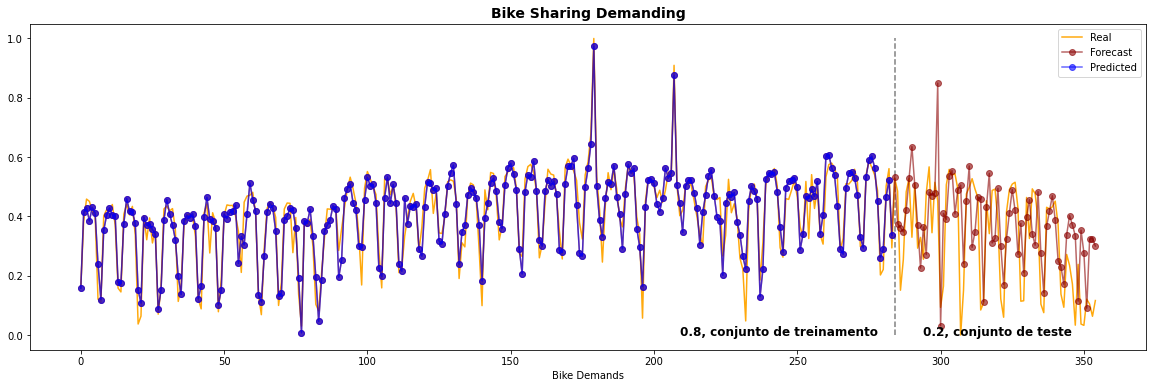

MSE: 	 1481928.88
MAPE: 	 0.55
ME: 	 346.96
MAE: 	 964.52
MPE: 	 0.38
RMSE: 	 1217.35
ACF1: 	 0.01
CORR: 	 0.50


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [298]:
plot_forecast(df[['t']] , data_predict, X_train) 

y_forecast = data_predict[train_size::].reshape(-1) * (max - min) + min
y_real = np.array( y[train_size::] ).reshape(-1) * (max - min) + min

cur_metrics = forecast_accuracy(y_forecast, y_real)

dict_metrics['Deep Learning LSTM Model'] = cur_metrics

In [299]:
dict_metrics

{'ARIMA Model': {'ACF1': -0.11701330390835246,
  'CORR': 0.8433428364384308,
  'MAE': 534.9993165058248,
  'MAPE': 0.26963908917889773,
  'ME': 109.2910925267071,
  'MPE': 0.15533242867978853,
  'MSE': 479701.7906266327,
  'RMSE': 692.6050755131907},
 'DecisionTreeRegressor': {'ACF1': 0.07462555222973005,
  'CORR': 0.7173771964163616,
  'MAE': 687.9577464788732,
  'MAPE': 0.3416564176951794,
  'ME': 180.1549295774648,
  'MPE': 0.20449460341016812,
  'MSE': 865131.5633802817,
  'RMSE': 930.1244881091357},
 'Deep Learning LSTM Model': {'ACF1': 0.00987466417173797,
  'CORR': 0.49820759415888605,
  'MAE': 964.5179,
  'MAPE': 0.5462617,
  'ME': 346.9598,
  'MPE': 0.37974203,
  'MSE': 1481928.9,
  'RMSE': 1217.3450106687094},
 'GradientBoostingRegressor': {'ACF1': 0.1470083421833475,
  'CORR': 0.8030654906931234,
  'MAE': 643.0855726254631,
  'MAPE': 0.39542885192593374,
  'ME': 369.836008559469,
  'MPE': 0.326591919188947,
  'MSE': 755297.0352621916,
  'RMSE': 869.0782676273706},
 'MLPRegre

Epoch: 0, loss: 0.21404
Epoch: 500, loss: 0.00736
Epoch: 1000, loss: 0.00380
Epoch: 1500, loss: 0.00316
Epoch: 0, loss: 0.24347
Epoch: 500, loss: 0.00648
Epoch: 1000, loss: 0.00182
Epoch: 1500, loss: 0.00048
Epoch: 0, loss: 0.15072
Epoch: 500, loss: 0.00594
Epoch: 1000, loss: 0.00454
Epoch: 1500, loss: 0.00055
Epoch: 0, loss: 0.16955
Epoch: 500, loss: 0.00608
Epoch: 1000, loss: 0.00170
Epoch: 1500, loss: 0.00082
Epoch: 0, loss: 0.31266
Epoch: 500, loss: 0.00692
Epoch: 1000, loss: 0.00412
Epoch: 1500, loss: 0.00150
Epoch: 0, loss: 0.41000
Epoch: 500, loss: 0.00700
Epoch: 1000, loss: 0.00528
Epoch: 1500, loss: 0.00502
Epoch: 0, loss: 0.15755
Epoch: 500, loss: 0.00556
Epoch: 1000, loss: 0.00190
Epoch: 1500, loss: 0.00050
Epoch: 0, loss: 0.23543
Epoch: 500, loss: 0.00587
Epoch: 1000, loss: 0.00230
Epoch: 1500, loss: 0.00061
Epoch: 0, loss: 0.17913
Epoch: 500, loss: 0.00642
Epoch: 1000, loss: 0.00181
Epoch: 1500, loss: 0.00038
Epoch: 0, loss: 0.16141
Epoch: 500, loss: 0.00637
Epoch: 1000, l

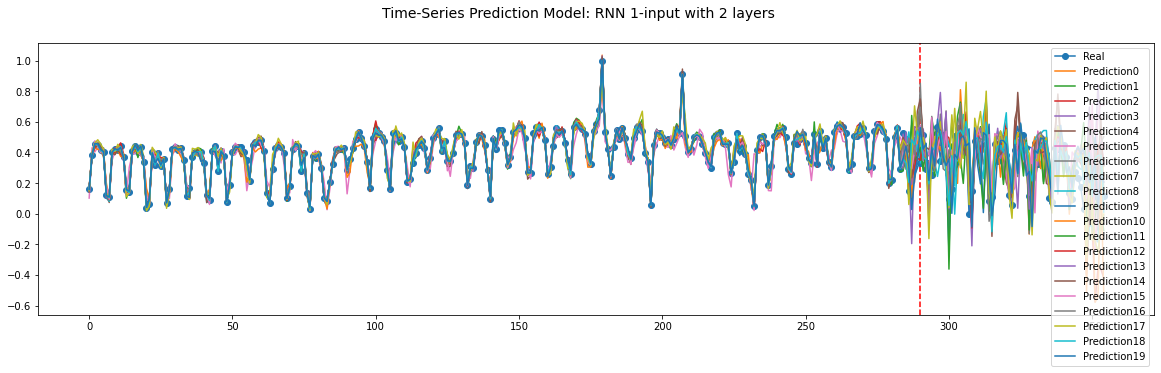

In [221]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1 # input size!!! agora com duas séries de entrada
hidden_size = 16

data_predict_list = []

for i in range(20):
  print(i)
  for num_layers in range(2,3):

    # num_layers = 1, 2, 3, 4

    model = LSTM(input_size, hidden_size, num_layers)
    model = model.to(device)

    loss_function = torch.nn.MSELoss()    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train(model, optimizer, loss_function, num_epochs, X_train, y_train)

    model.eval()
    prediction = model(X.to(device))
    data_predict = prediction.to('cpu').data.numpy()
    dataY_plot = y.to('cpu').data.numpy()

    data_predict_list.append(data_predict)
    
plt.figure(figsize=(20,5))
plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_plot, marker='o', label='Real')
for i in range(len(data_predict_list)):
  plt.plot(data_predict_list[i], Label='Prediction' + str(i))

plt.legend()
plt.suptitle(f'Time-Series Prediction Model: RNN 1-input with {num_layers} layers', fontsize=14)

plt.savefig('plot_rnn1_' + str(num_layers) + '_layers.png')
plt.show()

In [222]:
mean_predict = []
std_predict = []

nr_y_hat = len(data_predict_list[0])

for i in range(nr_y_hat):
  y_hat = []
  for d in data_predict_list:
    y_hat.append(d[i])
  mean_predict.append(np.array(y_hat).mean())
  std_predict.append(np.array(y_hat).std())

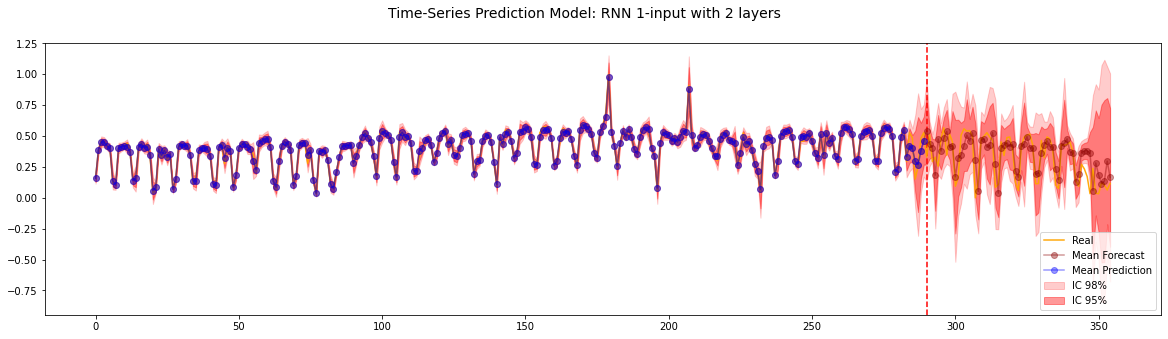

In [303]:
plt.figure(figsize=(20,5))
plt.axvline(x=train_size, c='r', linestyle='--')

#for i in range(len(data_predict_list)):
#  plt.plot(data_predict_list[i], Label='Prediction' + str(i))
mean_predict = np.array(mean_predict)
std_predict = np.array(std_predict)

plt.plot(y, color='orange', alpha=0.95, label='Real')
plt.plot(mean_predict, color='darkred', alpha=0.4, label='Mean Forecast', marker='o')
plt.plot(mean_predict[0:train_size], color='blue', alpha=0.4, Label='Mean Prediction', marker='o')

plt.fill_between(np.arange(0,355), mean_predict-3*std_predict, mean_predict+3*std_predict, label='IC 98%', color='red', alpha=.2)
plt.fill_between(np.arange(0,355), mean_predict-2*std_predict, mean_predict+2*std_predict, label='IC 95%', color='red', alpha=.4)


plt.legend(loc='lower right')
plt.suptitle(f'Time-Series Prediction Model: RNN 1-input with {num_layers} layers', fontsize=14)

plt.savefig('plot_rnn1_' + str(num_layers) + '_layers.png')
plt.show()